# Preference Learning Report Generator

This notebook generates plots for a single run directory.

Default `RESULTS_PATH` points to `../../results/hc_combo_20260110_024805/preference_learning`.


In [9]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

DATASET_LABELS = {
    'open_compas': 'OpenML COMPAS',
    'openml_bank_marketing': 'OpenML Bank Marketing',
    'openml_german_credit': 'OpenML German Credit',
}
MODEL_LABELS = {
    'decision_tree': 'Decision Tree',
    'gradient_boosting': 'Gradient Boosting',
    'logistic_regression': 'Logistic Regression',
    'mlp_classifier': 'Multilayer Perceptron',
}

# Path to either a single simulation JSON or a directory containing multiple JSON files.
RESULTS_PATH = Path('../../results/hc_combo_20260110_024805/preference_learning_new')
# Optional filters.
PERSONA_FILTER: str | None = None  # e.g. 'clinician' / 'regulator' / 'lay_user'
K_TO_PLOT = 3

def _suffix_from_path(path: Path) -> str:
    token = path.parent.name if path.suffix else path.name
    token = token or 'reports'
    return token.replace(' ', '_')

RUN_SUFFIX = _suffix_from_path(RESULTS_PATH)
REPORTS_DIR = (RESULTS_PATH.parent if RESULTS_PATH.suffix else RESULTS_PATH) / 'reports'
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

sns.set_theme(style='whitegrid')


In [10]:
def _iter_result_paths(path: Path) -> List[Path]:
    if path.is_dir():
        persona_jsons = list(path.rglob('persona_simulation_summary.json'))
        if persona_jsons:
            return sorted(persona_jsons)
        return sorted(path.rglob('*.json'))
    if path.is_file():
        return [path]
    return []


def load_simulation_results(path: Path = RESULTS_PATH) -> pd.DataFrame:
    records: List[Dict[str, object]] = []
    for json_path in _iter_result_paths(path):
        payload: Dict[str, Any] = json.loads(json_path.read_text(encoding='utf-8'))
        dataset = payload.get('dataset')
        model = payload.get('model')
        persona = payload.get('persona')
        tau = (
            (payload.get('persona_sampling') or {}).get('tau_override')
            or (payload.get('persona_config') or {}).get('tau')
        )
        if tau is None:
            per_user = payload.get('per_user') or []
            if per_user and isinstance(per_user, list) and isinstance(per_user[0], dict):
                tau = per_user[0].get('tau')
        try:
            tau = float(tau) if tau is not None else None
        except Exception:
            tau = None

        for method, key in (
            ('PersoXAI', 'aggregate_top_k_mean'),
            ('AutoXAI', 'aggregate_autoxai_hpo_per_instance_top_k_mean'),
            # ('AutoXAI', 'aggregate_autoxai_hpo_overall_top_k_mean'),
        ):
            top_k = payload.get(key) or {}
            for k, stats in top_k.items():
                try:
                    k_int = int(k)
                except Exception:
                    continue
                spearman = 0.0
                if isinstance(stats, dict):
                    rank_corr = stats.get('rank_correlation')
                    if isinstance(rank_corr, dict):
                        spearman = float(rank_corr.get('spearman') or 0.0)
                    else:
                        spearman = float(stats.get('rank_correlation.spearman') or 0.0)
                records.append(
                    {
                        'file': json_path.name,
                        'dataset': dataset,
                        'model': model,
                        'persona': persona,
                        'tau': tau,
                        'method': method,
                        'k': k_int,
                        'precision': float((stats or {}).get('precision', 0.0)),
                        'recall': float((stats or {}).get('recall', 0.0)),
                        'jaccard': float((stats or {}).get('jaccard', 0.0)),
                        'spearman': spearman,
                    }
                )
    df = pd.DataFrame(records)
    if df.empty:
        print(f'No simulation results found under: {path.resolve()}')
        return df
    print(f'Loaded {len(df)} rows from {df["file"].nunique()} JSON file(s).')
    return df


def _format_label(name: object) -> str:
    if not isinstance(name, str) or not name:
        return 'Unknown'
    return name.replace('_', ' ').title()


results_df = load_simulation_results()
if not results_df.empty:
    results_df['dataset_label'] = results_df['dataset'].map(DATASET_LABELS).fillna(results_df['dataset'].apply(_format_label))
    results_df['model_label'] = results_df['model'].map(MODEL_LABELS).fillna(results_df['model'].apply(_format_label))
    if PERSONA_FILTER is not None:
        results_df = results_df[results_df['persona'] == PERSONA_FILTER].copy()

plot_df = results_df[results_df['k'] == int(K_TO_PLOT)].copy() if not results_df.empty else results_df
plot_df.head()


Loaded 54 rows from 9 JSON file(s).


,file,dataset,model,persona,tau,method,k,precision,recall,jaccard,spearman,dataset_label,model_label
0,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,auto-xai-persona,0.01,PersoXAI,3,0.829167,0.829167,0.783437,0.313661,OpenML COMPAS,Decision Tree
3,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,auto-xai-persona,0.01,AutoXAI,3,0.431250,0.431250,0.346875,-0.430134,OpenML COMPAS,Decision Tree
6,persona_simulation_summary__open_compas__gradi...,open_compas,gradient_boosting,auto-xai-persona,0.01,PersoXAI,3,0.780208,0.780208,0.711562,0.443214,OpenML COMPAS,Gradient Boosting
9,persona_simulation_summary__open_compas__gradi...,open_compas,gradient_boosting,auto-xai-persona,0.01,AutoXAI,3,0.437500,0.437500,0.393750,-0.091295,OpenML COMPAS,Gradient Boosting
12,persona_simulation_summary__open_compas__mlp_c...,open_compas,mlp_classifier,auto-xai-persona,0.01,PersoXAI,3,0.776042,0.776042,0.692187,0.222500,OpenML COMPAS,Multilayer Perceptron


In [11]:
# Inspect encoded dataset sizes referenced by the simulation results.
ENCODED_BASE_DIR = RESULTS_PATH.parent / 'encoded_pareto_fronts' / 'features_full_lm_stats'
encoded_paths_raw = []
for json_path in _iter_result_paths(RESULTS_PATH):
    payload = json.loads(json_path.read_text(encoding='utf-8'))
    encoded_path_val = payload.get('encoded_path')
    if encoded_path_val:
        encoded_paths_raw.append(encoded_path_val)

def _resolve_encoded_path(path_str: str) -> Path:
    path = Path(path_str)
    candidates = [
        path,
        Path.cwd() / path,
        RESULTS_PATH.parent / path,
        ENCODED_BASE_DIR / path.name,
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate
    return path

encoded_paths = sorted({str(_resolve_encoded_path(p)) for p in encoded_paths_raw})
encoded_stats_rows: list[dict[str, object]] = []
for raw_path in encoded_paths:
    resolved = Path(raw_path)
    exists = resolved.exists()
    rows = None
    cols = None
    error = None
    if exists:
        try:
            df = pd.read_parquet(resolved)
            rows = len(df)
            cols = len(df.columns)
        except Exception as exc:  # notebook debug helper
            error = str(exc)
    encoded_stats_rows.append(
        {
            'encoded_path': str(resolved),
            'exists': exists,
            'rows': rows,
            'cols': cols,
            'error': error,
        }
    )

encoded_stats_df = pd.DataFrame(encoded_stats_rows)
encoded_stats_df


,encoded_path,exists,rows,cols,error
0,../../results/hc_combo_20260110_024805/encoded...,True,1750,75,None
1,../../results/hc_combo_20260110_024805/encoded...,True,1728,75,None
2,../../results/hc_combo_20260110_024805/encoded...,True,1714,75,None
3,../../results/hc_combo_20260110_024805/encoded...,True,1363,75,None
4,../../results/hc_combo_20260110_024805/encoded...,True,1784,75,None
5,../../results/hc_combo_20260110_024805/encoded...,True,1930,75,None
6,../../results/hc_combo_20260110_024805/encoded...,True,1347,75,None
7,../../results/hc_combo_20260110_024805/encoded...,True,1726,75,None
8,../../results/hc_combo_20260110_024805/encoded...,True,1900,75,None


In [12]:
# Preview column names from the first available encoded file.
if encoded_paths:
    preview_path = _resolve_encoded_path(encoded_paths[0])
else:
    preview_path = None

if preview_path and preview_path.exists():
    encoded_preview_df = pd.read_parquet(preview_path)
    print(f'Previewing encoded file: {preview_path}')
    print(f'Rows: {len(encoded_preview_df):,} | Columns: {len(encoded_preview_df.columns):,}')
    pd.DataFrame({'column': encoded_preview_df.columns}).head(50)
else:
    print('No encoded parquet found to preview (check encoded_path fields / ENCODED_BASE_DIR).')


Previewing encoded file: ../../results/hc_combo_20260110_024805/encoded_pareto_fronts/features_full_lm_stats/open_compas__decision_tree_pareto_encoded.parquet
Rows: 1,750 | Columns: 75


In [13]:
summary_df = (
    plot_df
    .groupby(['dataset', 'dataset_label', 'model', 'model_label', 'persona', 'method', 'k'])
    [['precision', 'recall', 'jaccard']]
    .mean()
    .reset_index()
)
if not summary_df.empty:
    file_base = f"summary_all_datasets_all_models_k{int(K_TO_PLOT)}_{RUN_SUFFIX}"
    summary_df.to_csv(REPORTS_DIR / f"{file_base}.csv", index=False)
summary_df


,dataset,dataset_label,model,model_label,persona,method,k,precision,recall,jaccard
0,open_compas,OpenML COMPAS,decision_tree,Decision Tree,auto-xai-persona,AutoXAI,3,0.431250,0.431250,0.346875
1,open_compas,OpenML COMPAS,decision_tree,Decision Tree,auto-xai-persona,PersoXAI,3,0.829167,0.829167,0.783437
2,open_compas,OpenML COMPAS,gradient_boosting,Gradient Boosting,auto-xai-persona,AutoXAI,3,0.437500,0.437500,0.393750
3,open_compas,OpenML COMPAS,gradient_boosting,Gradient Boosting,auto-xai-persona,PersoXAI,3,0.780208,0.780208,0.711562
4,open_compas,OpenML COMPAS,mlp_classifier,Multilayer Perceptron,auto-xai-persona,AutoXAI,3,0.408333,0.408333,0.334688
5,open_compas,OpenML COMPAS,mlp_classifier,Multilayer Perceptron,auto-xai-persona,PersoXAI,3,0.776042,0.776042,0.692187
6,openml_bank_marketing,OpenML Bank Marketing,decision_tree,Decision Tree,auto-xai-persona,AutoXAI,3,0.265625,0.265625,0.168125
7,openml_bank_marketing,OpenML Bank Marketing,decision_tree,Decision Tree,auto-xai-persona,PersoXAI,3,0.900000,0.900000,0.855000
8,openml_bank_marketing,OpenML Bank Marketing,gradient_boosting,Gradient Boosting,auto-xai-persona,AutoXAI,3,0.273958,0.273958,0.172188
9,openml_bank_marketing,OpenML Bank Marketing,gradient_boosting,Gradient Boosting,auto-xai-persona,PersoXAI,3,0.969792,0.969792,0.954688


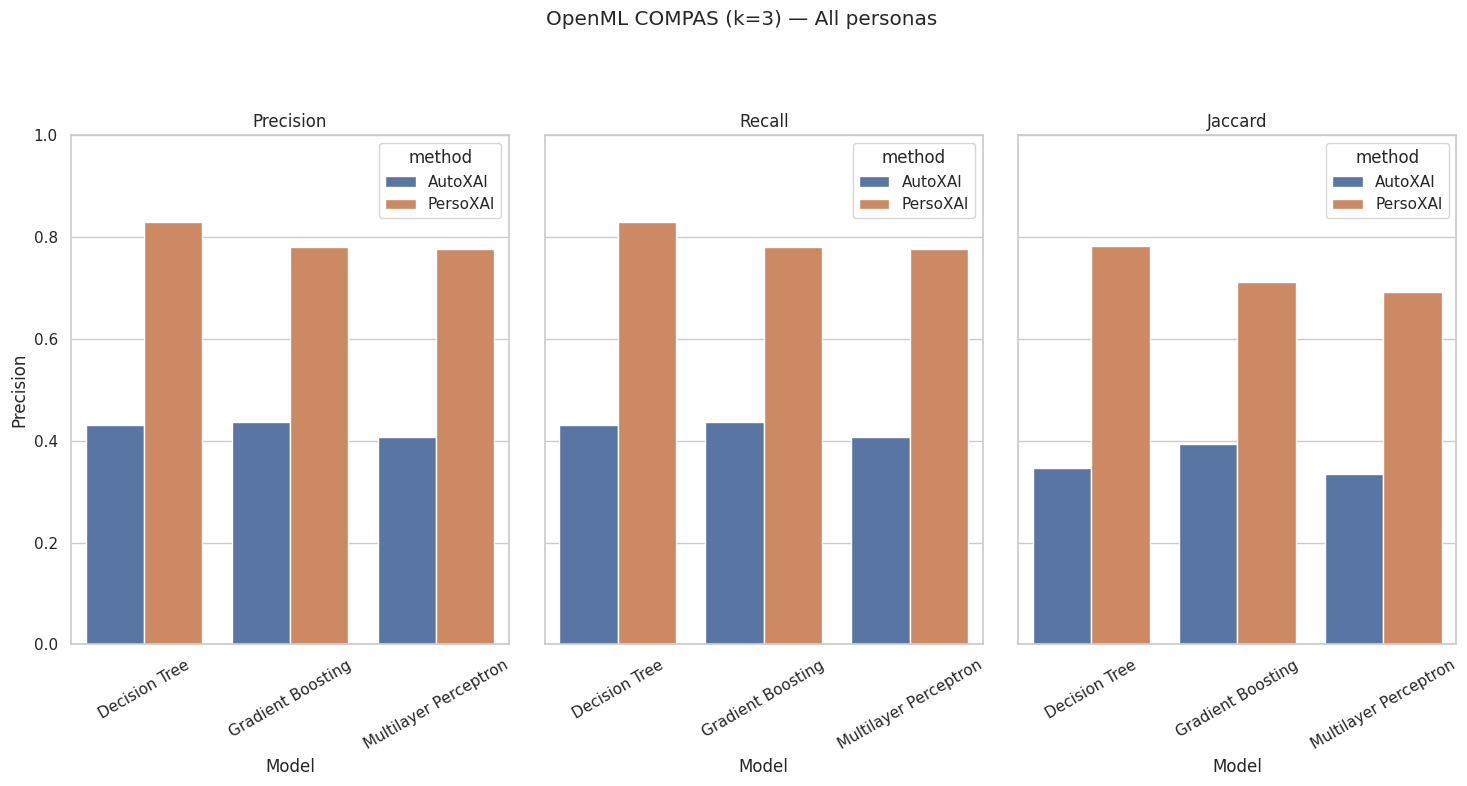

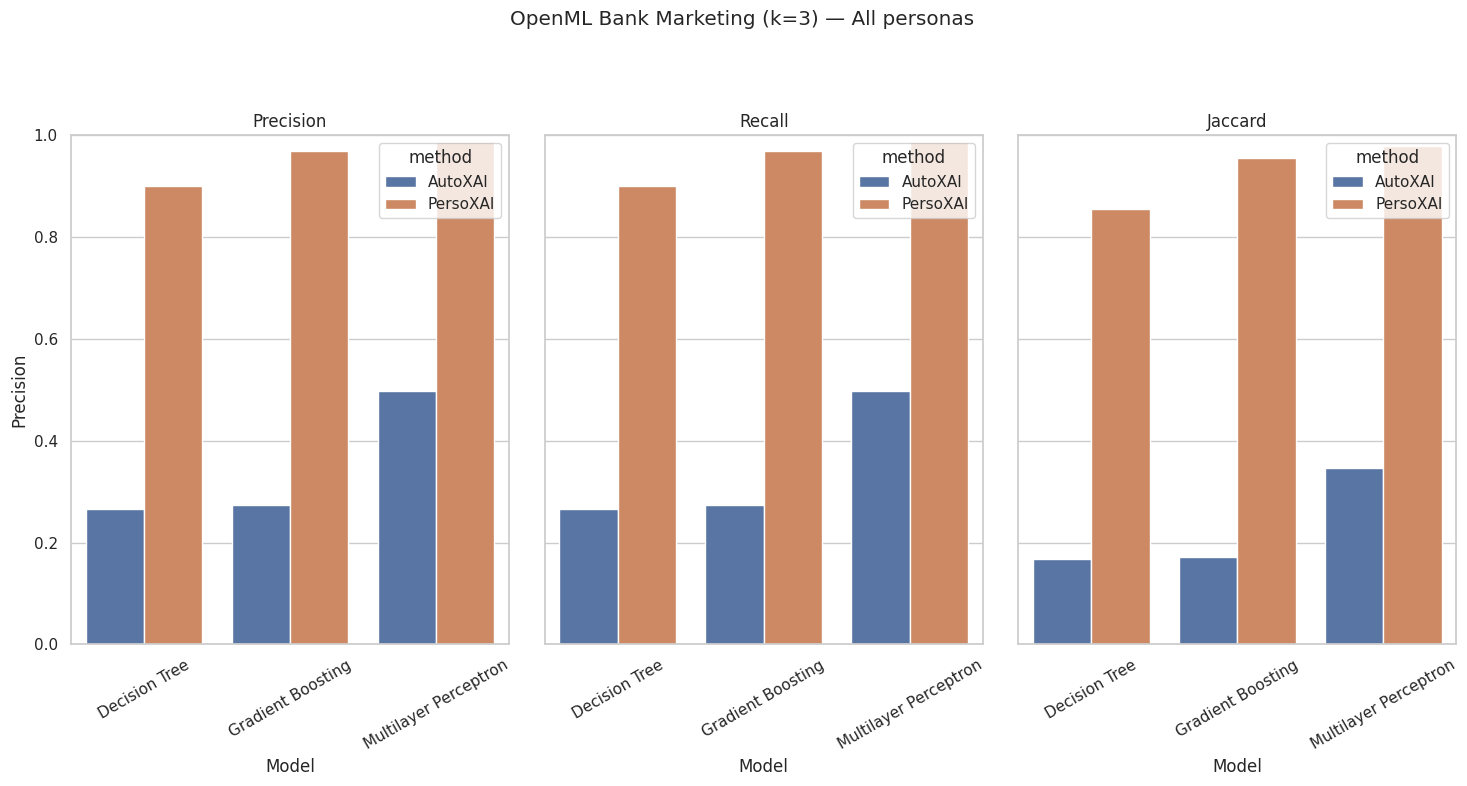

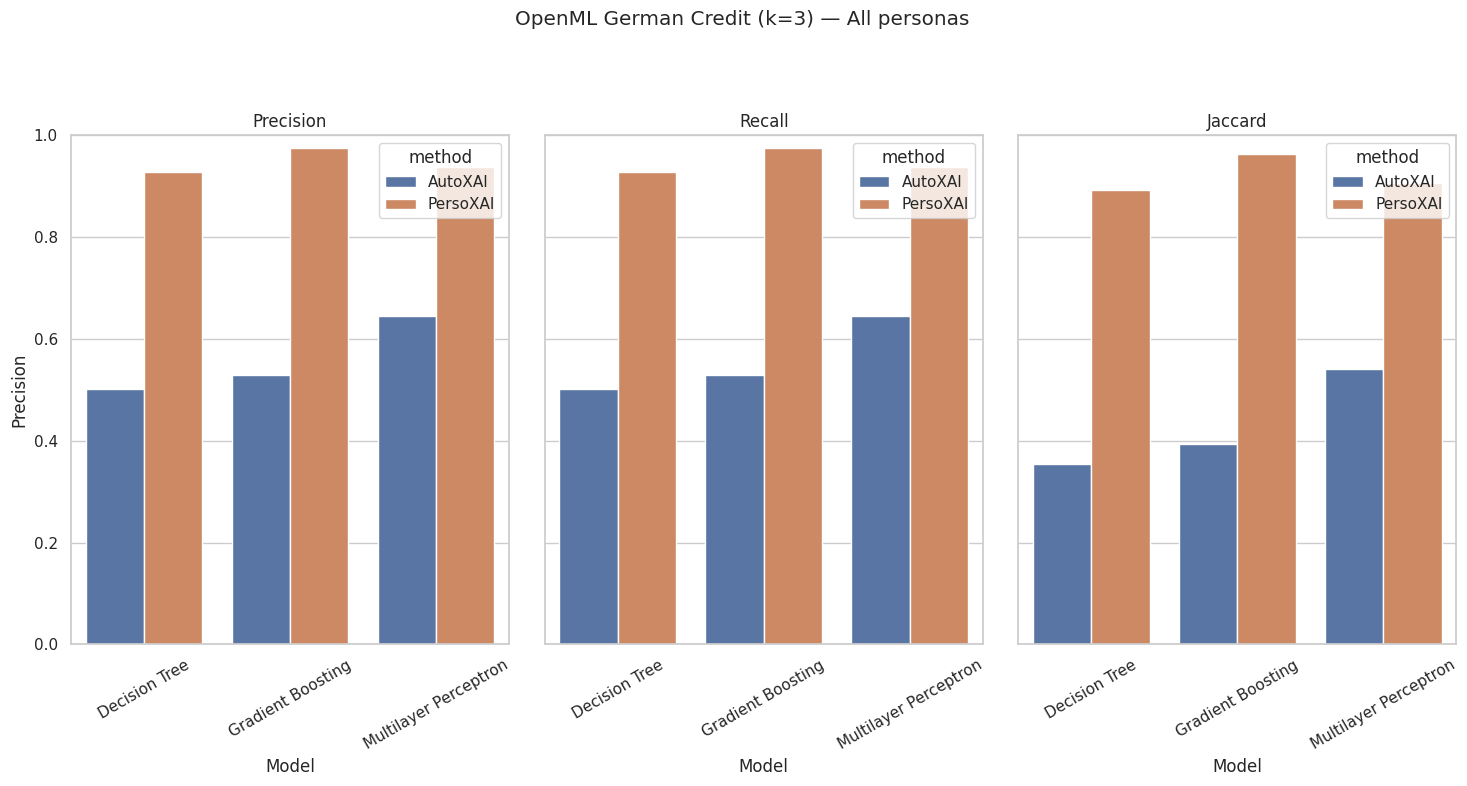

In [14]:
def plot_bars_by_dataset(df: pd.DataFrame) -> None:
    if df.empty:
        print('No rows to plot (check RESULTS_PATH / PERSONA_FILTER / K_TO_PLOT).')
        return

    model_order = [MODEL_LABELS[key] for key in MODEL_LABELS if (df['model'] == key).any()]
    for dataset_key, subset in df.groupby('dataset', sort=True):
        dataset_label = subset['dataset_label'].iloc[0]
        fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharey=True)
        for ax, metric in zip(axes, ['precision', 'recall', 'jaccard']):
            sns.barplot(
                data=subset,
                x='model_label',
                y=metric,
                hue='method',
                order=model_order if model_order else None,
                ax=ax,
            )
            ax.set_title(metric.title())
            ax.set_xlabel('Model')
            ax.set_ylabel(metric.title())
            ax.set_ylim(0, 1)
            ax.tick_params(axis='x', rotation=30)
        persona_title = f"Persona={PERSONA_FILTER}" if PERSONA_FILTER else 'All personas'
        fig.suptitle(f'{dataset_label} (k={int(K_TO_PLOT)}) — {persona_title}')
        fig.tight_layout(rect=[0, 0, 1, 0.92])
        file_base = f"bars_{dataset_key}_all_models_precision_recall_jaccard_k{int(K_TO_PLOT)}_{RUN_SUFFIX}"
        fig.savefig(REPORTS_DIR / f"{file_base}.png", dpi=300, bbox_inches='tight')
        fig.savefig(REPORTS_DIR / f"{file_base}.pdf", dpi=300, bbox_inches='tight', format='pdf')
        plt.show()
        plt.close(fig)


plot_bars_by_dataset(summary_df)


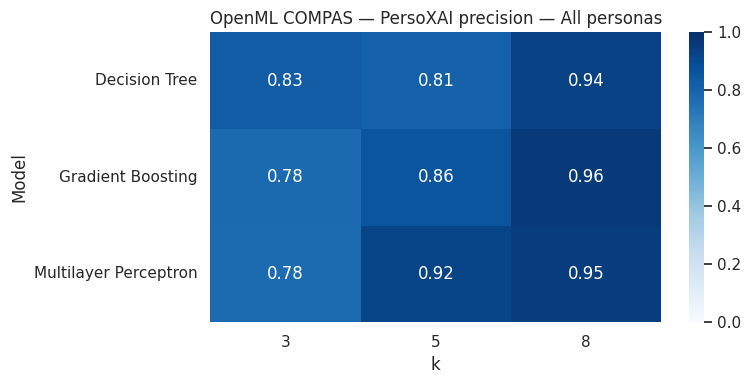

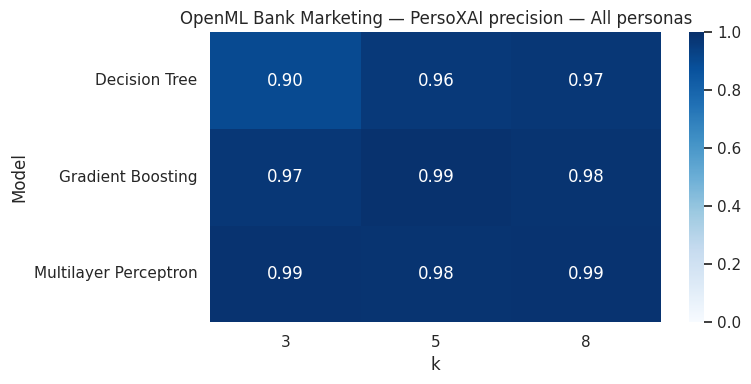

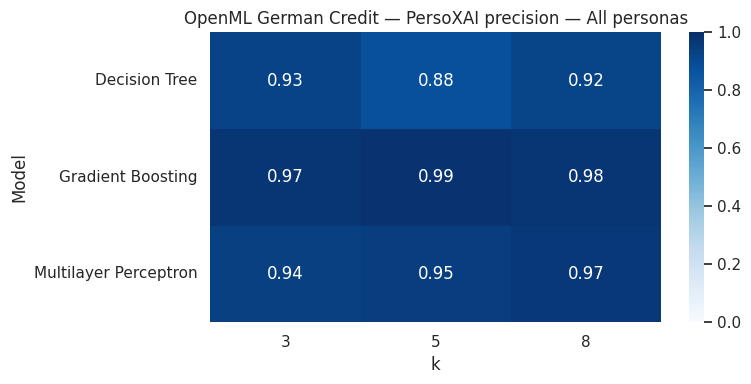

In [15]:
HEATMAP_METHOD = 'PersoXAI'  # 'PersoXAI' / 'AutoXAI'
HEATMAP_METRIC = 'precision'  # 'precision' / 'recall' / 'jaccard'

heatmap_source = results_df.copy()
if PERSONA_FILTER is not None and not heatmap_source.empty:
    heatmap_source = heatmap_source[heatmap_source['persona'] == PERSONA_FILTER].copy()
if not heatmap_source.empty:
    heatmap_source['dataset_label'] = heatmap_source['dataset'].map(DATASET_LABELS).fillna(heatmap_source['dataset'].apply(_format_label))
    heatmap_source['model_label'] = heatmap_source['model'].map(MODEL_LABELS).fillna(heatmap_source['model'].apply(_format_label))

for dataset_key, subset in heatmap_source[heatmap_source['method'] == HEATMAP_METHOD].groupby('dataset', sort=True):
    dataset_label = subset['dataset_label'].iloc[0]
    pivot = subset.pivot_table(index='model_label', columns='k', values=HEATMAP_METRIC, aggfunc='mean')
    if pivot.empty:
        continue
    pivot = pivot.reindex(columns=sorted(pivot.columns))
    fig, ax = plt.subplots(figsize=(8, max(4, 0.6 * len(pivot))))
    sns.heatmap(pivot, annot=True, fmt='.2f', vmin=0, vmax=1, cmap='Blues', ax=ax)
    persona_title = f"Persona={PERSONA_FILTER}" if PERSONA_FILTER else 'All personas'
    ax.set_title(f'{dataset_label} — {HEATMAP_METHOD} {HEATMAP_METRIC} — {persona_title}')
    ax.set_xlabel('k')
    ax.set_ylabel('Model')
    fig.tight_layout()
    file_base = f"heatmap_{dataset_key}_all_models_{HEATMAP_METHOD}_{HEATMAP_METRIC}_{RUN_SUFFIX}"
    fig.savefig(REPORTS_DIR / f"{file_base}.png", dpi=300, bbox_inches='tight')
    fig.savefig(REPORTS_DIR / f"{file_base}.pdf", dpi=300, bbox_inches='tight', format='pdf')
    pivot.to_csv(REPORTS_DIR / f"{file_base}.csv")
    plt.show()
    plt.close(fig)


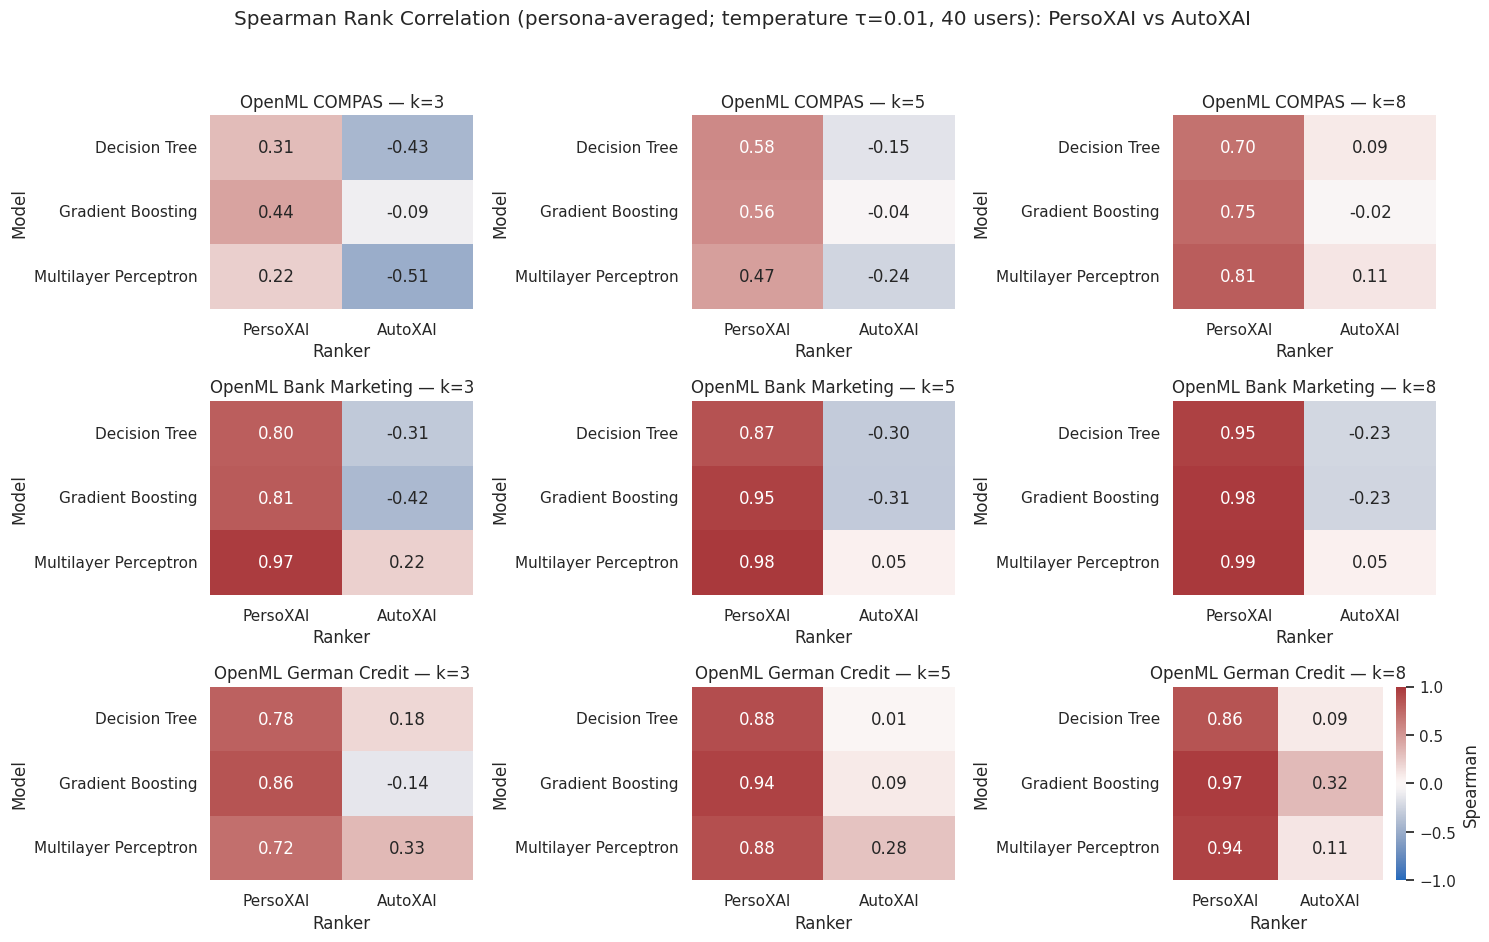

In [16]:
# Spearman heatmaps (persona-averaged): PersoXAI vs AutoXAI

K_VALUES = [3, 5, 8]
DATASETS_TO_PLOT = ['open_compas', 'openml_bank_marketing', 'openml_german_credit']

spearman_source = results_df.copy()
if spearman_source.empty:
    print('No results loaded (check RESULTS_PATH).')
else:
    spearman_df = (
        spearman_source[spearman_source['k'].isin(K_VALUES)]
        .groupby(['persona', 'dataset', 'model', 'method', 'k'])['spearman']
        .mean()
        .reset_index()
        .groupby(['dataset', 'model', 'method', 'k'])['spearman']
        .mean()
        .reset_index()
    )

    spearman_df['dataset_label'] = (
        spearman_df['dataset']
        .map(DATASET_LABELS)
        .fillna(spearman_df['dataset'].apply(_format_label))
    )
    spearman_df['model_label'] = (
        spearman_df['model']
        .map(MODEL_LABELS)
        .fillna(spearman_df['model'].apply(_format_label))
    )

    tau_values = []
    if 'tau' in spearman_source.columns:
        tau_values = [v for v in spearman_source['tau'].dropna().unique().tolist() if v is not None]
    tau_values = sorted(set(float(v) for v in tau_values))
    if len(tau_values) == 1:
        temperature_title = f"τ={tau_values[0]:g}"
    elif len(tau_values) == 0:
        temperature_title = 'τ=?'
    else:
        temperature_title = f"τ∈[{min(tau_values):g}, {max(tau_values):g}]"

    datasets = [d for d in DATASETS_TO_PLOT if (spearman_df['dataset'] == d).any()]
    if not datasets:
        datasets = sorted(spearman_df['dataset'].dropna().unique().tolist())

    n_rows = len(datasets)
    n_cols = len(K_VALUES)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3.2 * n_rows), squeeze=False)
    fig.subplots_adjust(right=0.88, bottom=0.10, top=0.90, wspace=0.35, hspace=0.35)
    for row_idx, dataset_key in enumerate(datasets):
        dataset_label = DATASET_LABELS.get(dataset_key, _format_label(dataset_key))
        for col_idx, k in enumerate(K_VALUES):
            ax = axes[row_idx][col_idx]
            subset = spearman_df[(spearman_df['dataset'] == dataset_key) & (spearman_df['k'] == int(k))].copy()
            if subset.empty:
                ax.axis('off')
                continue

            pivot_table = subset.pivot_table(index='model_label', columns='method', values='spearman', aggfunc='mean')
            desired_cols = ['PersoXAI', 'AutoXAI']
            pivot_table = pivot_table.reindex(columns=[c for c in desired_cols if c in pivot_table.columns])

            present_models = set(subset['model'])
            model_order = [
                MODEL_LABELS.get(model_key, _format_label(model_key))
                for model_key in MODEL_LABELS
                if model_key in present_models
            ]
            if model_order:
                pivot_table = pivot_table.reindex(model_order)

            mask = pivot_table.isna()
            sns.heatmap(
                pivot_table,
                annot=True,
                fmt='.2f',
                cmap='vlag',
                vmin=-1,
                vmax=1,
                mask=mask,
                ax=ax,
                cbar=(row_idx == n_rows - 1 and col_idx == n_cols - 1),
                cbar_kws={'label': 'Spearman'} if (row_idx == n_rows - 1 and col_idx == n_cols - 1) else None,
            )
            ax.set_title(f"{dataset_label} — k={k}")
            ax.set_xlabel('Ranker')
            ax.set_ylabel('Model')

    fig.suptitle(
        f"Spearman Rank Correlation (persona-averaged; temperature {temperature_title}, 40 users): PersoXAI vs AutoXAI"
    )
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    out_base = f"spearman_heatmaps_all_datasets_all_models_{RUN_SUFFIX}"
    fig.savefig(REPORTS_DIR / f"{out_base}.png", dpi=300, bbox_inches='tight')
    fig.savefig(REPORTS_DIR / f"{out_base}.pdf", dpi=300, bbox_inches='tight', format='pdf')
    spearman_df.to_csv(REPORTS_DIR / f"{out_base}_values.csv", index=False)
    plt.show()
    plt.close(fig)


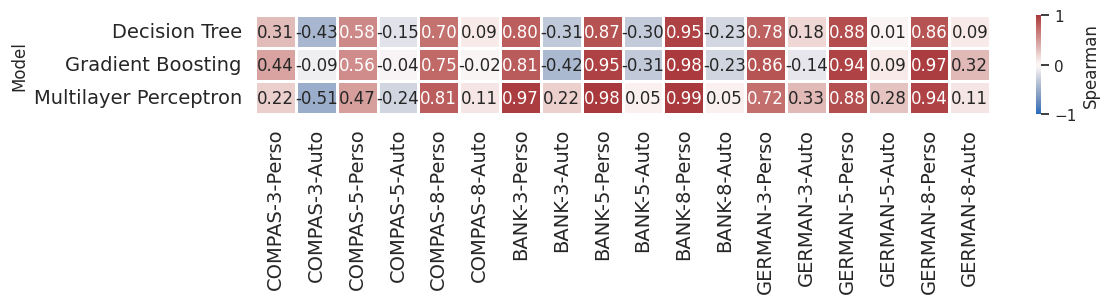

In [18]:
# --- Compact single-heatmap version (two subcolumns per dataset×k) ---

K_VALUES = [3, 5, 8]
DATASETS_TO_PLOT = ['open_compas', 'openml_bank_marketing', 'openml_german_credit']

DATASET_SHORT = {
    'open_compas': 'COMPAS',
    'openml_bank_marketing': 'BANK',
    'openml_german_credit': 'GERMAN',
}

spearman_source = results_df.copy()
if spearman_source.empty:
    print('No results loaded (check RESULTS_PATH).')
else:
    spearman_df = (
        spearman_source[spearman_source['k'].isin(K_VALUES)]
        .groupby(['persona', 'dataset', 'model', 'method', 'k'])['spearman']
        .mean()
        .reset_index()
        .groupby(['dataset', 'model', 'method', 'k'])['spearman']
        .mean()
        .reset_index()
    )

    spearman_df['model_label'] = spearman_df['model'].map(MODEL_LABELS).fillna(spearman_df['model'].apply(_format_label))

    datasets = [d for d in DATASETS_TO_PLOT if (spearman_df['dataset'] == d).any()]
    if not datasets:
        datasets = sorted(spearman_df['dataset'].dropna().unique().tolist())

    wide = (
        spearman_df
        .pivot_table(
            index='model_label',
            columns=['dataset', 'k', 'method'],
            values='spearman',
            aggfunc='mean',
        )
    )

    keep_methods = ['PersoXAI', 'AutoXAI']
    wide = wide.loc[:, wide.columns.get_level_values(2).isin(keep_methods)]

    ordered_cols = []
    for d in datasets:
        for k in K_VALUES:
            for m in keep_methods:
                col = (d, int(k), m)
                if col in wide.columns:
                    ordered_cols.append(col)
    wide = wide.reindex(columns=pd.MultiIndex.from_tuples(ordered_cols, names=wide.columns.names))

    present_models = set(spearman_df['model'])
    model_order = [MODEL_LABELS.get(model_key, _format_label(model_key)) for model_key in MODEL_LABELS if model_key in present_models]
    if model_order:
        wide = wide.reindex(model_order)

    def _col_label(d: str, k: int, m: str) -> str:
        d_short = DATASET_SHORT.get(d, DATASET_LABELS.get(d, _format_label(d)))
        m_short = 'Perso' if m == 'PersoXAI' else 'Auto'
        return f"{d_short}-{k}-{m_short}"

    wide.columns = [_col_label(d, k, m) for (d, k, m) in wide.columns]

    ncols = wide.shape[1]
    nrows = wide.shape[0]
    fig_w = max(12, 0.55 * ncols)
    fig_h = max(3.2, 0.55 * nrows)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    mask = wide.isna()
    sns.heatmap(
        wide,
        annot=True,
        fmt='.2f',
        cmap='vlag',
        vmin=-1,
        vmax=1,
        mask=mask,
        cbar=True,
        cbar_kws={'label': 'Spearman'},
        ax=ax,
        linewidths=0.8,
        linecolor='white',
        annot_kws={'fontsize': 12},
    )

    ax.set_xlabel('')
    ax.set_ylabel('Model')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=14)

    for x in range(2, ncols, 2):
        ax.axvline(x, color='white', linewidth=2)

    fig.tight_layout()

    out_base = f"spearman_heatmap_compact_all_datasets_all_models_{RUN_SUFFIX}"
    fig.savefig(REPORTS_DIR / f"{out_base}.png", dpi=500, bbox_inches='tight')
    fig.savefig(REPORTS_DIR / f"{out_base}.pdf", dpi=500, bbox_inches='tight', format='pdf')
    wide.to_csv(REPORTS_DIR / f"{out_base}_values.csv")

    plt.show()
    plt.close(fig)
